In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

from circuit_extract import visualize_circuit_masks
import circuit_extract as ce
import inference
import train

/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we

In [2]:
import importlib

importlib.reload(inference)
importlib.reload(train)
importlib.reload(ce)

<module 'circuit_extract' from '/home/cabbagepatch/Code/MI/vast/Mechanistic-Interpretability/circuit_extract.py'>

In [7]:
def model_config(ds_name: str, lr: float, epochs: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "epochs": epochs, 
        "lr": lr,
        # "pfrac": pfrac,
    }

def circuit_config(ds_name: str, lr: float, cepochs: int, k_w: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "cepochs": cepochs, 
        "lr": lr,
        "k_w": k_w,
    }
    

### Train Sparse Model ###

In [8]:
print("\n--- Phase 1: Initialize Model ---")
inp_shape = (1, 28, 28)
model = inference.CNN(nc=1, nf=16, num_classes=10, inp_shape=inp_shape)


--- Phase 1: Initialize Model ---


In [9]:
print("\n--- Phase 2: Train Sparse Baseline ---")
def scheduler(start, end, start_sparsity, target_sparsity, alpha):
    def f(epochs):
        t = min(max(0, epochs-start), end-start)/ (end-start)
        t = t**alpha
        return (target_sparsity* t + (1-t) * start_sparsity)
    return f

sched = scheduler(3, 12, 1, 0.05, 0.5)
# sched(0)
# for epoch in range(1,12):
#     print(sched(epoch+1))

cfg = model_config(ds_name='mnist', lr=1e-3, epochs=12)
device = cfg['device']
print(f"Running on {device}")

train.train_model(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    # pfrac=cfg['pfrac'],
    scheduler = sched, 
    ds_name="mnist-baseline",
    eps=1e-8,
    epochs=cfg['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
Running on cpu
n_params 20490 n_params_wd 20432
cpu


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9520 | Test Acc: 0.9532
Epoch 1 | Train Acc: 0.9716 | Test Acc: 0.9730
Epoch 2 | Train Acc: 0.9805 | Test Acc: 0.9811
Epoch 3 | Train Acc: 0.9834 | Test Acc: 0.9818
Epoch 4 | Train Acc: 0.9851 | Test Acc: 0.9842
Epoch 5 | Train Acc: 0.9864 | Test Acc: 0.9845
Epoch 6 | Train Acc: 0.9866 | Test Acc: 0.9845
Epoch 7 | Train Acc: 0.9861 | Test Acc: 0.9855
Epoch 8 | Train Acc: 0.9837 | Test Acc: 0.9818
Epoch 9 | Train Acc: 0.9775 | Test Acc: 0.9767
Epoch 10 | Train Acc: 0.9622 | Test Acc: 0.9643
Epoch 11 | Train Acc: 0.8937 | Test Acc: 0.8958


In [10]:
print(f'CUDA available: {torch.cuda.is_available()}') 
print(f'Device count: {torch.cuda.device_count()}')
print(f'Current device: {torch.cuda.current_device() if torch.cuda.is_available() else None}')


CUDA available: False
Device count: 0
Current device: None


In [11]:
non_zero = sum([(p != 0).sum() for p in model.parameters()])
total = sum([p.numel() for p in model.parameters()])

print(f"{non_zero/total:.4f}")

# when retaining also retain other ones
# scheduler also add (50 percent of training steos then reach sparsity)
# iteratively sparsify features after starting from 0 percent sparsty
# circuits should not rely on 
# for every neuron retain some weights
# try pretraining on generation
#try on more complex datasets, cmnist, cifar10, pacs
#maybe try portability
#try training on
#try the weird loss thing
#mistake : apply sigmoid estimator
#see this as an angle to improve DG
#how to work with circuits that are not end to end // have to use bigger models
#ha405 // visual reasoning
#how to find neurons/circuits correspoding to sprurious features / circuits
#work with different circuits in cross-domain settings
#randomization makes network more generalizable
#maybe try and find work in compilers?
#LLMs ka kaam karo
#senior



0.0499


### Extracting circuit for each class

In [74]:
def run_class_circuit(class_idx: int, model, epochs=9, l0_lambda=0.05):
    """
    Extracts and visualizes a circuit for a specific target class (0-9).
    """
    print(f" Processing Class {class_idx} ")
    
    # 1. Setup Configuration for specific class
    ds_name = f"mnist-class-{class_idx}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Configuration: Device={device}, Lambda={l0_lambda}, Dataset={ds_name}")

    # 2. Extract Circuit
    circuit = train.extract_circuit(
        model=model,
        lr=1e-3,
        b1=0.9, b2=0.999,
        ds_name=ds_name,     
        eps=1e-8,
        epochs=epochs,
        device=device,
        l0_lambda=l0_lambda,
        seed=42
    )

    # 3. Visualize
    print(f"\n--- Visualizing Circuit for Class {class_idx} ---")
    
    try:
        visualize_circuit_masks(circuit) 
        
        import os
        if os.path.exists("circuit_visualization.png"):
            os.rename("circuit_visualization.png", f"circuit_viz_class_{class_idx}.png")
            print(f"Saved visualization to: circuit_viz_class_{class_idx}.png")
            
    except Exception as e:
        print(f"Visualization failed: {e}")

    return circuit

In [75]:
circuit_0 = run_class_circuit(0, model)

 Processing Class 0 
Configuration: Device=cuda, Lambda=0.05, Dataset=mnist-class-0


/venv/dev/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/venv/dev/lib/python3.10/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Calculating mean activations...
Initializing Circuit...
Extracting Circuit (L0 Lambda=0.05)...
Epoch 0 | Loss: 2195.9630 | Avg Mask: 0.984 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 1 | Loss: 2195.9640 | Avg Mask: 0.973 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 2 | Loss: 2195.9639 | Avg Mask: 0.961 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 3 | Loss: 2195.9634 | Avg Mask: 0.950 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 4 | Loss: 2195.9639 | Avg Mask: 0.938 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 5 | Loss: 2195.9644 | Avg Mask: 0.925 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 6 | Loss: 2195.9641 | Avg Mask: 0.913 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 7 | Loss: 2195.9658 | Avg Mask: 0.900 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262
Epoch 8 | Loss: 2195.9631 | Avg Mask: 0.888 | Total Non-Zero: 43914.0 | | Circuit Acc: 0.9262

--- Visualizing Circuit for Class 0 ---
Visualization fail

 Analysis: Disconnected vs Unmasked 


ValueError: xmax must be a single scalar value, but got 0.06466051936149597

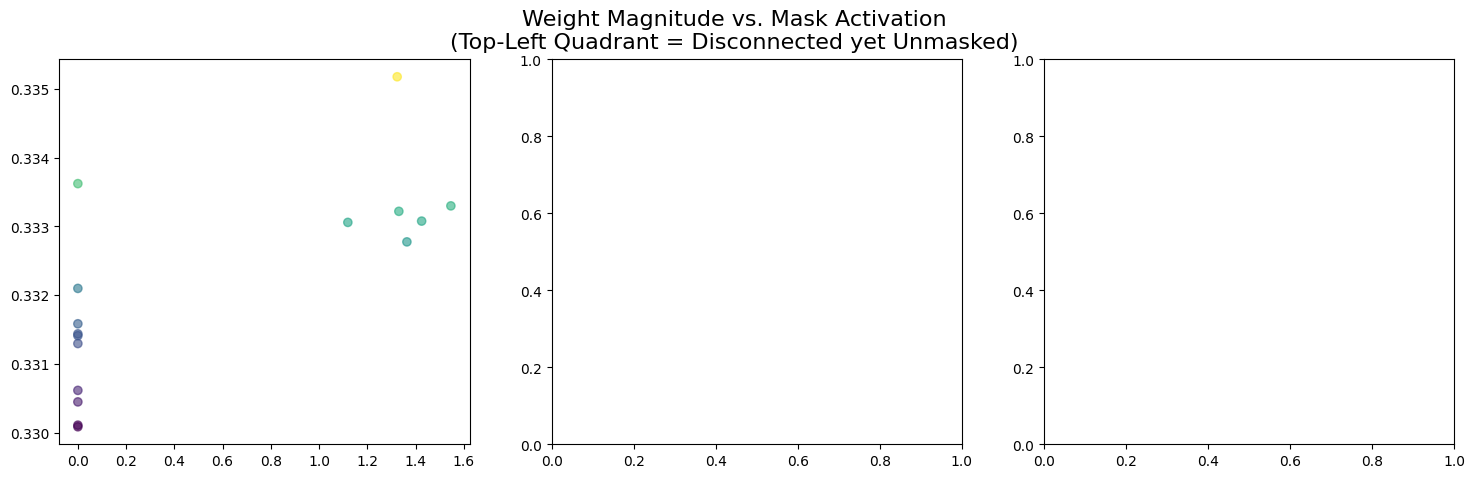

In [20]:
ce.analyze_disconnected_unmasked(circuit_0)

In [ ]:
circuit_1 = run_class_circuit(1, model)

In [ ]:
circuit_2 = run_class_circuit(2, model)

In [ ]:
circuit_3 = run_class_circuit(3, model)

In [ ]:
circuit_4 = run_class_circuit(4, model)

In [ ]:
circuit_5 = run_class_circuit(5, model)

In [ ]:
circuit_6 = run_class_circuit(6, model)

In [ ]:
circuit_7 = run_class_circuit(7, model)

In [ ]:
circuit_8 = run_class_circuit(8, model)

In [ ]:
circuit_9 = run_class_circuit(9, model)

### Finetuned layer

In [ ]:
print("\n--- Phase 2: Train Sparse Baseline ---")
train.finetune(
    model=model,
    num_classes=2,
    lr=cfg['baseline']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['baseline']['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
n_params 23628 n_params_wd 23568


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9357 | Test Acc: 0.9456
Epoch 1 | Train Acc: 0.9511 | Test Acc: 0.9550
Epoch 2 | Train Acc: 0.9436 | Test Acc: 0.9498


In [64]:
# 3. Extract Circuit
print("\n--- Phase 3: Extract Circuit ---")
# Note: We pass the *trained* model to the circuit extractor
cfg['circuit']['l0_lambda'] = 0.0001
cfg['circuit']['lr'] = 1e-2
cfg['circuit']['epochs'] = 20
circuit = train.extract_circuit(
    model=model,
    lr=cfg['circuit']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['circuit']['epochs'],
    device=device,
    l0_lambda=cfg['circuit']['l0_lambda'],
    seed=cfg['seed']
)


--- Phase 3: Extract Circuit ---
Calculating mean activations...


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Initializing Circuit...
Extracting Circuit (L0 Lambda=0.0001)...
Epoch 0 | Loss: 4.3552 | Avg Mask: -1.278 | Total Non-Zero: 2337.0 | | Circuit Acc: 0.0434
Epoch 1 | Loss: 1.8895 | Avg Mask: -1.573 | Total Non-Zero: 1367.0 | | Circuit Acc: 0.5566
Epoch 2 | Loss: 1.6700 | Avg Mask: -1.780 | Total Non-Zero: 1140.0 | | Circuit Acc: 0.5740
Epoch 3 | Loss: 1.6140 | Avg Mask: -1.947 | Total Non-Zero: 971.0 | | Circuit Acc: 0.5545
Epoch 4 | Loss: 1.5956 | Avg Mask: -2.092 | Total Non-Zero: 911.0 | | Circuit Acc: 0.5580
Epoch 5 | Loss: 1.5883 | Avg Mask: -2.225 | Total Non-Zero: 867.0 | | Circuit Acc: 0.5582
Epoch 6 | Loss: 1.5836 | Avg Mask: -2.351 | Total Non-Zero: 821.0 | | Circuit Acc: 0.5423
Epoch 7 | Loss: 1.5765 | Avg Mask: -2.473 | Total Non-Zero: 773.0 | | Circuit Acc: 0.5486
Epoch 8 | Loss: 1.5830 | Avg Mask: -2.591 | Total Non-Zero: 755.0 | | Circuit Acc: 0.5336
Epoch 9 | Loss: 1.5876 | Avg Mask: -2.707 | Total Non-Zero: 740.0 | | Circuit Acc: 0.5346
Epoch 10 | Loss: 1.5878 | Avg Ma

In [73]:
x = circuit.masks[-6].mask.data

sum(x > 0) / x.numel()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0006, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0003, 0.0000,
         0.0000, 0.0000, 0.0003, 0.0003, 0.0000],
        [0.0000, 0.0000, 0.0003, 0.0000, 0.0013, 0.0010, 0.0003, 0.0006, 0.0006,
         0.0000, 0.0000, 0.0003, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0016, 0.0022, 0.0013, 0.0016, 0.0000,
         0.0003, 0.0003, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0003, 0.0010, 0.0019, 0.0016, 0.0010, 0.0003,
         0.0000, 0.0000, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0006, 0.0010, 0.0013, 0.0013, 0.0013, 0.0003, 0.0000,
  